## Libraries

In [3]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing
import copy

## Parameters

In [4]:
PATIENT_ID = '2B2'
INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'

PATCH_DIM_X = 1000
PATCH_DIM_Y = 1000
SIZE_THRESHOLD = 500
NORMALISE_COUNT = False

## Read nodes

In [143]:
nodes = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')

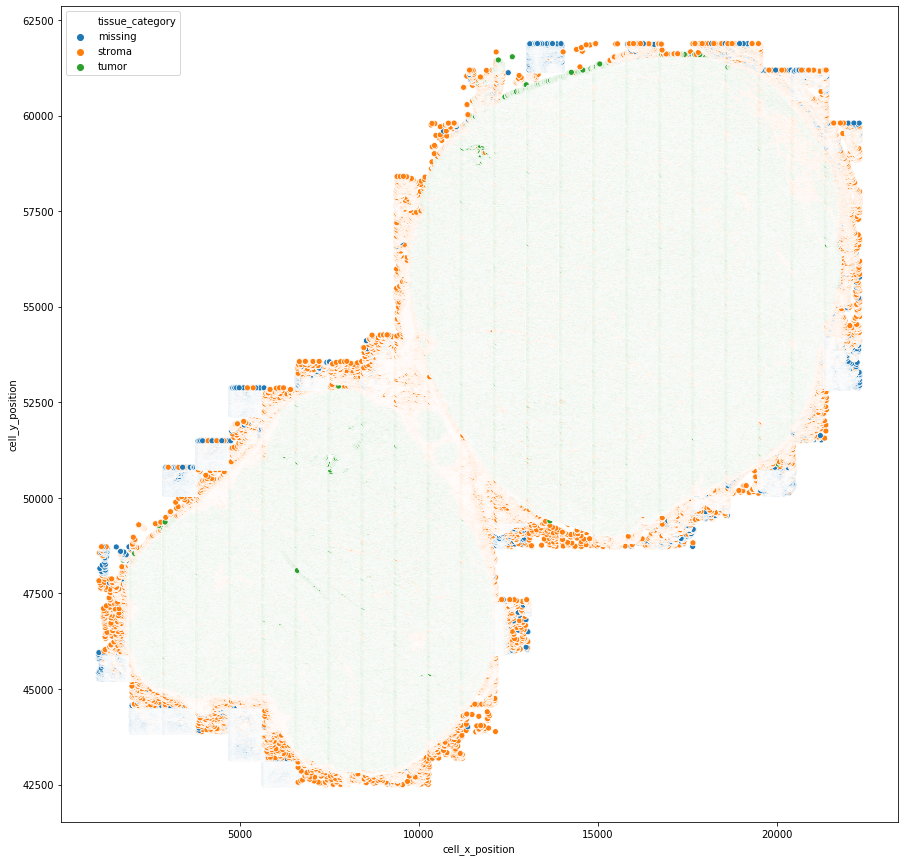

In [144]:
fig, ax = plt.subplots(figsize = (15,15))
sns.scatterplot(data = nodes , x='cell_x_position', y= 'cell_y_position',hue='tissue_category').get_figure().savefig(PLOT_PATH+'All_tissue.png');


In [4]:
nodes.head()

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border
0,1,14040.7,37383.4,stroma,stroma,False
1,2,14049.6,37381.9,stroma,MISSING,False
2,3,14056.5,37381.9,stroma,MISSING,False
3,4,14088.8,37381.9,stroma,MISSING,False
4,5,14114.1,37382.4,stroma,MISSING,False


In [5]:
nodes_sorted_x = nodes.sort_values(['cell_x_position'])

In [6]:
shifted_x = nodes_sorted_x['cell_x_position'] - min(nodes_sorted_x['cell_x_position'])
nodes_sorted_x['patch_x'] = shifted_x//PATCH_DIM_X

In [7]:
nodes_sorted_y = nodes_sorted_x.sort_values(['cell_y_position'])
shifted_y = nodes_sorted_y['cell_y_position'] - min(nodes_sorted_y['cell_y_position'])
nodes_sorted_y['patch_y'] = shifted_y//PATCH_DIM_Y

In [8]:
nodes_sorted_y['patch'] = nodes_sorted_y.apply(lambda row: (row.patch_x,row.patch_y), axis=1)

In [9]:
#fig, ax = plt.subplots(figsize = (15,15))
#unique = nodes_sorted_y["patch"].unique()
#palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
#color = random.shuffle(sns.color_palette())
#sns.scatterplot(data = nodes_sorted_y , x='cell_x_position', y= 'cell_y_position', hue = 'patch', palette =palette)
#plt.savefig('./plots/patches_'+PATIENT_ID+'.png')

In [10]:
columns = ['cell_id','patch']
patch_mapping = nodes_sorted_y[columns]

# Size patches

In [11]:
patch_sizes = pd.DataFrame(patch_mapping.patch.value_counts()).reset_index().rename(columns = {'index':'patch','patch':'patch_size'})

In [12]:
patch_mapping = patch_mapping.merge(patch_sizes, on='patch', how = 'left')

In [13]:
nodes_sorted_y['patch_size'] = patch_mapping['patch_size']

In [14]:
nodes = nodes_sorted_y.drop(['patch_x','patch_y'],axis=1)

In [15]:
nodes.head(2)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border,patch,patch_size
3,4,14088.8,37381.9,stroma,MISSING,False,"(1.0, 0.0)",3883
1,2,14049.6,37381.9,stroma,MISSING,False,"(1.0, 0.0)",573


In [16]:
del nodes_sorted_x
del nodes_sorted_y

# Read edges

In [17]:
edges = pd.read_csv(OUTPUT_PATH + 'graph_edges.csv')

In [18]:
edges = edges.merge(patch_mapping , left_on = 'cell_id_1', right_on = 'cell_id', how='left')
edges = edges.merge(patch_mapping , left_on = 'cell_id_2', right_on = 'cell_id', how='left')

In [19]:
edges = edges.drop(['cell_id_x','cell_id_y','patch_size_y'], axis =1)
edges = edges.rename(columns={'patch_x':'patch_1','patch_y':'patch_2','patch_size_x':'patch_size'})

In [20]:
inter_patch = (edges.patch_1 != edges.patch_2).value_counts()[False]
intra_patch = (edges.patch_1 != edges.patch_2).value_counts()[True]
print('inter-patch edges: ',inter_patch )
print('intra-patch edges: ',intra_patch )

inter-patch edges:  2071075
intra-patch edges:  38635


In [21]:
edges = edges[(edges.patch_1 == edges.patch_2)]
edges = edges.drop(['patch_2'], axis =1)
edges = edges.rename(columns ={'patch_1' : 'patch'})

# Patch filtering 

In [23]:
nodes = nodes[nodes.patch_size>SIZE_THRESHOLD]
edges = edges[edges.patch_size>SIZE_THRESHOLD]

In [24]:
unique_patchs = nodes.groupby(['patch']).agg('count').reset_index()['patch'].values
patch_number = pd.DataFrame({'patch':unique_patchs, 'patch_number': range(len(unique_patchs))})

In [26]:
nodes = nodes.merge(patch_number, on='patch', how='left')

In [27]:
edges = edges.merge(patch_number, on='patch', how='left')

# Plotting Grid Graph

In [ ]:
def add_edge_to_graph(G, e1, e2, w):
    G.add_edge(e1, e2)


G = nx.Graph()
points = list(unique_patchs)  # (x,y) points
edges = [(0, 1, 10), (1, 2, 5), (2, 3, 25), (0, 3, 3), (3, 4, 8)]  # (v1,v2, weight)

for i in range(len(edges)):
    add_edge_to_graph(G, points[edges[i][0]], points[edges[i][1]], edges[i][2])

# you want your own layout
# pos = nx.spring_layout(G)
pos = {point: point for point in points}

# add axis
fig, ax = plt.subplots()
nx.draw(G, pos=pos, node_color='k', ax=ax)
nx.draw(G, pos=pos, node_size=1500, ax=ax)  # draw nodes and edges
nx.draw_networkx_labels(G, pos=pos)  # draw node labels/names
# draw edge weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
plt.axis("on")
ax.set_xlim(0, 11)
ax.set_ylim(0,11)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

## Localisation patches

In [162]:
localisation_columns = ['patch_number','patch', 'cell_x_position','cell_y_position']
localisation_nodes = nodes[localisation_columns]
localisation_patch = localisation_nodes.groupby(['patch']).agg('mean').reset_index()

## Number of border cells

In [163]:
border_grouped = nodes.groupby(['patch','on_border']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
on_border_grouped_pivotted = pd.pivot_table(border_grouped, values='count', index=['patch'],columns=['on_border'], aggfunc=np.sum).reset_index()
on_border_grouped_pivotted.columns.name = None
on_border_grouped_pivotted = on_border_grouped_pivotted.fillna(0)
on_border_grouped_pivotted = on_border_grouped_pivotted.rename(columns = {False:'out_of_border',True:'in_border'})


In [164]:
patch_data = localisation_patch.merge(on_border_grouped_pivotted, on='patch', how='left')

# Edge count per patch

In [165]:
edges = edges[(edges.phenotype_1 != 'MISSING') & (edges.phenotype_2 != 'MISSING')]

edge_phenotype_count = edges.groupby(['patch','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

number_per_patch = edges.groupby(['patch']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'total_edge_per_patch'})

edge_phenotype_count = edge_phenotype_count.merge(number_per_patch,on='patch',how='left')

if NORMALISE_COUNT == True :
    edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']/edge_phenotype_count['total_edge_per_patch']

if NORMALISE_COUNT == False :
    edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']

    
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

edge_phenotype_count = edge_phenotype_count[['patch','edge_count_ratio','edge_type']]


edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count_ratio', index=['patch'],
                    columns=['edge_type'], aggfunc=np.sum)

edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)

columns = edge_phenotype_count_pivotted.columns[1:]


In [167]:
patch_data = patch_data.merge(edge_phenotype_count_pivotted, on='patch', how='left')

## Nodes regions  phenotype count

In [168]:
nodes['region'] = nodes.apply(lambda x : regions(x.tissue_category, x.on_border), axis =1)
nodes_grouped = nodes.groupby(['patch','region','phenotype']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
nodes_grouped['region_phenotype'] = nodes_grouped.apply(lambda row: row.region + '_region_' + row.phenotype , axis = 1)
nodes_grouped = nodes_grouped.merge(patch_sizes, on='patch', how ='left')
if NORMALISE_COUNT == True:
    nodes_grouped['count'] = nodes_grouped['count']/nodes_grouped['patch_size']
region_count_grouped_pivotted = pd.pivot_table(nodes_grouped, values='count', index=['patch'],columns=['region_phenotype'], aggfunc=np.sum).reset_index()
region_count_grouped_pivotted.columns.name = None
region_count_grouped_pivotted = region_count_grouped_pivotted.fillna(0)



In [169]:
patch_data = patch_data.merge(region_count_grouped_pivotted, on='patch', how='left')

# Defining Grid Graph

In [191]:
edges_data = patch_data[['patch_number','patch']].copy()
edges_data['key'] = 0

edges_data = edges_data.merge(edges_data, how = 'left', on = 'key')

edges_data['distance'] = edges_data.apply(lambda row: np.linalg.norm(np.array(row.patch_x) - np.array(row.patch_y)), axis=1)

edges_data = edges_data[edges_data['distance'] == 1]

edges_data = edges_data.drop(['key'], axis=1)
edges_data = edges_data.rename(columns={'patch_number_x':'patch_number_1','patch_x':'patch_1','patch_number_y':'patch_number_2','patch_y':'patch_2'})

edges_data.head(2)


,patch_number_1,patch_1,patch_number_2,patch_2,distance
1,0,"(0.0, 3.0)",1,"(0.0, 4.0)",1.0
6,0,"(0.0, 3.0)",6,"(1.0, 3.0)",1.0


In [192]:
len(edges_data)

180

# extracting for all Patients

In [37]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
files = os.listdir(Directory_path)



for file in files[61:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        
        INPUT_PATH = './data/input/DEEPMEL_' + PATIENT_ID + '/'
        OUTPUT_PATH = './data/output/DEEPMEL_' + PATIENT_ID +'/'
        PLOT_PATH ='./plots/DEEPMEL_' + PATIENT_ID +'/'
        
        print('Treating patient : ' + PATIENT_ID )
        print('Reading nodes : ')
        nodes = pd.read_csv(OUTPUT_PATH+'nodes_with_border.csv')
        
        nodes_sorted_x = nodes.sort_values(['cell_x_position'])
        
        shifted_x = nodes_sorted_x['cell_x_position'] - min(nodes_sorted_x['cell_x_position'])
        nodes_sorted_x['patch_x'] = shifted_x//PATCH_DIM_X
        
        nodes_sorted_y = nodes_sorted_x.sort_values(['cell_y_position'])
        shifted_y = nodes_sorted_y['cell_y_position'] - min(nodes_sorted_y['cell_y_position'])
        nodes_sorted_y['patch_y'] = shifted_y//PATCH_DIM_Y
        
        nodes_sorted_y['patch'] = nodes_sorted_y.apply(lambda row: (row.patch_x,row.patch_y), axis=1)
        
        print('number of patches : ', len(nodes_sorted_y.patch.unique()))
        
        columns = ['cell_id','patch']
        patch_mapping = nodes_sorted_y[columns]
        
        
        
        patch_sizes = pd.DataFrame(patch_mapping.patch.value_counts()).reset_index().rename(columns = {'index':'patch','patch':'patch_size'})
        
        patch_mapping = patch_mapping.merge(patch_sizes, on='patch', how = 'left')
        
        nodes_sorted_y['patch_size'] = patch_mapping['patch_size']
        nodes = nodes_sorted_y.drop(['patch_x','patch_y'],axis=1)
        
        del nodes_sorted_x
        del nodes_sorted_y
        
        
        print('Reading edges... ')
        
        edges = pd.read_csv(OUTPUT_PATH + 'graph_edges.csv')
        
        edges = edges.merge(patch_mapping , left_on = 'cell_id_1', right_on = 'cell_id', how='left')
        edges = edges.merge(patch_mapping , left_on = 'cell_id_2', right_on = 'cell_id', how='left')
        
        edges = edges.drop(['cell_id_x','cell_id_y','patch_size_y'], axis =1)
        edges = edges.rename(columns={'patch_x':'patch_1','patch_y':'patch_2','patch_size_x':'patch_size'})
        
        inter_patch = (edges.patch_1 != edges.patch_2).value_counts()[False]
        intra_patch = (edges.patch_1 != edges.patch_2).value_counts()[True]
        print('inter-patch edges: ',inter_patch )
        print('intra-patch edges: ',intra_patch )
        
        edges = edges[(edges.patch_1 == edges.patch_2)]
        edges = edges.drop(['patch_2'], axis =1)
        edges = edges.rename(columns ={'patch_1' : 'patch'})
        
        
        print('Patch filtering...')
        
        nodes = nodes[nodes.patch_size>SIZE_THRESHOLD]
        edges = edges[edges.patch_size>SIZE_THRESHOLD]
        unique_patchs = nodes.groupby(['patch']).agg('count').reset_index()['patch'].values
        patch_number = pd.DataFrame({'patch':unique_patchs, 'patch_number': range(len(unique_patchs))})
        print('number of patches remaining: ', len(nodes.patch.unique()))
        
        nodes = nodes.merge(patch_number, on='patch', how='left')
        edges = edges.merge(patch_number, on='patch', how='left')

        
        
        print('Localisation')
        localisation_columns = ['patch_number','patch', 'cell_x_position','cell_y_position']
        localisation_nodes = nodes[localisation_columns]
        localisation_patch = localisation_nodes.groupby(['patch']).agg('mean').reset_index()
        
        print('Region count')

        border_grouped = nodes.groupby(['patch','on_border']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
        on_border_grouped_pivotted = pd.pivot_table(border_grouped, values='count', index=['patch'],columns=['on_border'], aggfunc=np.sum).reset_index()
        on_border_grouped_pivotted.columns.name = None
        on_border_grouped_pivotted = on_border_grouped_pivotted.fillna(0)
        on_border_grouped_pivotted = on_border_grouped_pivotted.rename(columns = {False:'out_of_border',True:'in_border'})
        
        patch_data = localisation_patch.merge(on_border_grouped_pivotted, on='patch', how='left')
        
        edges = edges[(edges.phenotype_1 != 'MISSING') & (edges.phenotype_2 != 'MISSING')]

        
        print('Edge count')

        edge_phenotype_count = edges.groupby(['patch','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

        number_per_patch = edges.groupby(['patch']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'total_edge_per_patch'})

        edge_phenotype_count = edge_phenotype_count.merge(number_per_patch,on='patch',how='left')

        if NORMALISE_COUNT == True :
            edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']/edge_phenotype_count['total_edge_per_patch']

        if NORMALISE_COUNT == False :
            edge_phenotype_count['edge_count_ratio'] = edge_phenotype_count['edge_count']

    
        edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

        edge_phenotype_count = edge_phenotype_count[['patch','edge_count_ratio','edge_type']]


        edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count_ratio', index=['patch'],
                    columns=['edge_type'], aggfunc=np.sum)

        edge_phenotype_count_pivotted.columns.name = None
        edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
        edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)
        
        
        patch_data = patch_data.merge(edge_phenotype_count_pivotted, on='patch', how='left')
        
        print('Region phenotype count')

        nodes_without_missing = nodes[nodes.tissue_category != 'missing']
        nodes_without_missing['region'] = nodes_without_missing.apply(lambda x : regions(x.tissue_category, x.on_border), axis =1)
        nodes_grouped = nodes_without_missing.groupby(['patch','region','phenotype']).agg('count')['cell_id'].reset_index().rename(columns = {'cell_id':'count'})
        nodes_grouped['region_phenotype'] = nodes_grouped.apply(lambda row: row.region + '_region_' + row.phenotype , axis = 1)
        nodes_grouped = nodes_grouped.merge(patch_sizes, on='patch', how ='left')
        if NORMALISE_COUNT == True:
            nodes_grouped['count'] = nodes_grouped['count']/nodes_grouped['patch_size']
        region_count_grouped_pivotted = pd.pivot_table(nodes_grouped, values='count', index=['patch'],columns=['region_phenotype'], aggfunc=np.sum).reset_index()
        region_count_grouped_pivotted.columns.name = None
        region_count_grouped_pivotted = region_count_grouped_pivotted.fillna(0)

        
        patch_data = patch_data.merge(region_count_grouped_pivotted, on='patch', how='left')
        
        
        
        patch_data.to_csv(OUTPUT_PATH + 'patch_data.csv', index = False)
        
        print('Extracting Grid Graph Edges')
        
        edges_data = patch_data[['patch_number','patch']].copy()
        edges_data['key'] = 0

        edges_data = edges_data.merge(edges_data, how = 'left', on = 'key')

        edges_data['distance'] = edges_data.apply(lambda row: np.linalg.norm(np.array(row.patch_x) - np.array(row.patch_y)), axis=1)

        edges_data = edges_data[edges_data['distance'] == 1]

        edges_data = edges_data.drop(['key'], axis=1)
        edges_data = edges_data.rename(columns={'patch_number_x':'patch_number_1','patch_x':'patch_1','patch_number_y':'patch_number_2','patch_y':'patch_2'})

       

        edges_data.to_csv(OUTPUT_PATH + 'patch_edge_data.csv', index = False)

        
        
        


Treating patient : 1D1
Reading nodes : 
number of patches :  53
Reading edges... 
inter-patch edges:  795421
intra-patch edges:  14446
Patch filtering...
number of patches remaining:  53
Localisation
Region count
Edge count
Region phenotype count


/Users/asmisouhail/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Extracting Grid Graph Edges
Treating patient : 1N1
Reading nodes : 
number of patches :  158
Reading edges... 
inter-patch edges:  2472113
intra-patch edges:  42897
Patch filtering...
number of patches remaining:  158
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 2X1
Reading nodes : 
number of patches :  164
Reading edges... 
inter-patch edges:  3701577
intra-patch edges:  68437
Patch filtering...
number of patches remaining:  164
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 3A1
Reading nodes : 
number of patches :  172
Reading edges... 
inter-patch edges:  3234363
intra-patch edges:  51939
Patch filtering...
number of patches remaining:  172
Localisation
Region count
Edge count
Region phenotype count
Extracting Grid Graph Edges
Treating patient : 2Q1
Reading nodes : 
number of patches :  48
Reading edges... 
inter-patch edges:  1269860
intra-patch edges:  21806
Pa

In [38]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
files = os.listdir(Directory_path)
columns_list = []
for file in files[58:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        patch_features_df = pd.read_csv(Directory_path+'/'+file+'/patch_data.csv')
        columns = patch_features_df.columns
        for column in columns :
            if ((len(column.split('_'))==2) and (column.split('_')[0] == 'missing')) or ((len(column.split('_'))==3) and (column.split('_')[2] =='MISSING')) :
                patch_features_df = patch_features_df.drop([column], axis =1) 
                print('column : ' + column +' dropped ')
                
    
                
        columns = patch_features_df.columns
        
        print('Patient : '+ PATIENT_ID +' n_features :', len(columns))
        columns_list = Union(columns_list,columns)
        patch_features_df.to_csv(Directory_path+'/'+file+'/patch_data_1.csv', index = False)

    else:
        continue

column : border_region_MISSING dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISSING dropped 
Patient : 2J1 n_features : 56
column : border_region_MISSING dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISSING dropped 
Patient : 1V1 n_features : 56
column : border_region_MISSING dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISSING dropped 
Patient : 2R1 n_features : 44
column : border_region_MISSING dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISSING dropped 
Patient : 1D1 n_features : 57
column : border_region_MISSING dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISSING dropped 
Patient : 1N1 n_features : 55
column : border_region_MISSING dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISSING dropped 
Patient : 2X1 n_features : 54
column : border_region_MISSING dropped 
column : stroma_region_MISSING dropped 
column : tumor_region_MISS

In [39]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
files = os.listdir(Directory_path)
for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        
        patch_features_df = pd.read_csv(Directory_path+'/'+file+'/patch_data_1.csv')
        columns_df = patch_features_df.columns
        for column in columns_list:
            if not(column in columns_df):
                patch_features_df[column] = 0
                
        columns_df = patch_features_df.columns   
        print('Patient : '+PATIENT_ID +' n_features :', len(columns_df)) 
        patch_features_df.to_csv(Directory_path+'/'+file+'/patch_data_1.csv', index = False)


Patient : 2P1 n_features : 67
Patient : 3I1 n_features : 67
Patient : 1F1 n_features : 67
Patient : 1L1 n_features : 67
Patient : 3C1 n_features : 67
Patient : 2U2 n_features : 67
Patient : 2Z1 n_features : 67
Patient : 3J1 n_features : 67
Patient : 2S1 n_features : 67
Patient : 1J2 n_features : 67
Patient : 1E1 n_features : 67
Patient : 1O1 n_features : 67
Patient : 2Y1 n_features : 67
Patient : 2K1 n_features : 67
Patient : 2A1 n_features : 67
Patient : 1W1 n_features : 67
Patient : 1X2 n_features : 67
Patient : 2H1 n_features : 67
Patient : 1X3 n_features : 67
Patient : 2B1 n_features : 67
Patient : 2L1 n_features : 67
Patient : 1P1 n_features : 67
Patient : 2O1 n_features : 67
Patient : 1Y1 n_features : 67
Patient : 1V2 n_features : 67
Patient : 1S1 n_features : 67
Patient : 2E1 n_features : 67
Patient : 2W1 n_features : 67
Patient : 3N1 n_features : 67
Patient : 3D1 n_features : 67
Patient : 1K1 n_features : 67
Patient : 3M1 n_features : 67
Patient : 2T1 n_features : 67
Patient : 

In [61]:
patch_features_df = pd.read_csv(Directory_path+'/DEEPMEL_1C1/patch_data_1.csv')

In [62]:
len(patch_features_df)

61

In [63]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
files = os.listdir(Directory_path)
for file in files[:]:
    
    array = file.split('_')
    if len(array)==2:
        condition = array[0]
        PATIENT_ID = array[1]
    else:
        condition = ''
        
    
    if condition == 'DEEPMEL':
        
        patch_features_df = pd.read_csv(Directory_path+'/'+file+'/patch_data_1.csv')
        print(PATIENT_ID + ':', len(patch_features_df))


2P1: 169
3I1: 255
1F1: 50
1L1: 65
3C1: 294
2U2: 225
2Z1: 324
3J1: 54
2S1: 29
1J2: 25
1E1: 150
1O1: 159
2Y1: 383
2K1: 47
2A1: 39
1W1: 297
1X2: 58
2H1: 326
1X3: 136
2B1: 28
2L1: 368
1P1: 142
2O1: 102
1Y1: 222
1V2: 127
1S1: 277
2E1: 44
2W1: 296
3N1: 31
3D1: 211
1K1: 17
3M1: 373
2T1: 37
3G1: 82
1C1: 61
2U1: 129
3F1: 58
1O2: 74
2V1: 31
3E1: 122
3J2: 58
1J1: 63
1X1: 53
1R1: 150
2D1: 120
2B2: 280
2K3: 499
2G1: 137
3P1: 309
2C1: 118
1Z2: 384
1U1: 103
2J1: 75
1V1: 141
2R1: 31
1D1: 53
1N1: 158
2X1: 164
3A1: 172
2Q1: 48
3H1: 358
1M1: 43
2T2: 39


## Plotting GRID GRAPHS

In [18]:
Directory = os.getcwd()
Directory_path = Directory + '/data/output'
PATIENT_ID = '1C1'
patch_features_df = pd.read_csv(Directory_path+'/DEEPMEL_'+ PATIENT_ID +'/patch_data_1.csv')
patch_edges = pd.read_csv(Directory_path+'/DEEPMEL_'+ PATIENT_ID +'/patch_edge_data.csv')

In [19]:
import re
def get_coordinates(string):
    a , b = string.split(',')
    
    pattern = r'[() ]'
    
    a = int(re.sub(pattern, '', a).split('.')[0])
    b = int(re.sub(pattern, '', b).split('.')[0])
    
    return a,b

In [20]:
patch_features_df['patch'] = patch_features_df['patch'].apply(lambda x: get_coordinates(x))

In [21]:
points = patch_features_df.patch.values

In [22]:
patch_edges_ = patch_edges[patch_edges.patch_number_1 <patch_edges.patch_number_2]

In [23]:
edges = []
for index, row in patch_edges.iterrows():
    edges.append((row.patch_number_1,row.patch_number_2))
    
    

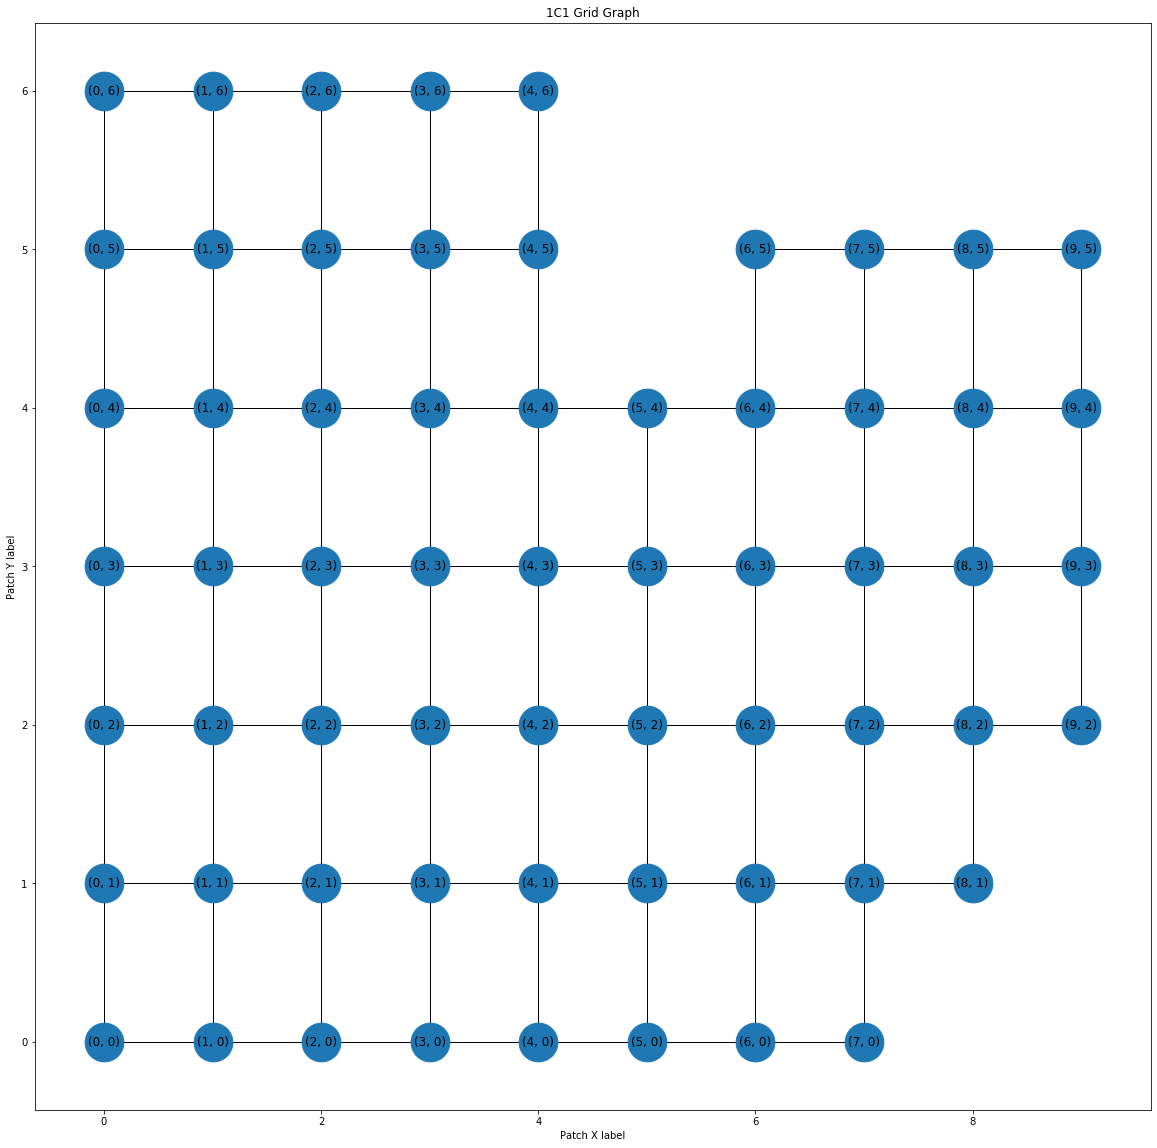

In [24]:
def add_edge_to_graph(G, e1, e2):
    G.add_edge(e1, e2)


G = nx.Graph()
  # (v1,v2, weight)

for i in range(len(edges)):
    add_edge_to_graph(G, points[edges[i][0]], points[edges[i][1]])

# you want your own layout
# pos = nx.spring_layout(G)
pos = {point: point for point in points}

# add axis
fig, ax = plt.subplots(figsize = (20,20))
nx.draw(G, pos=pos, node_color='k', ax=ax)
nx.draw(G, pos=pos, node_size=1500, ax=ax)  # draw nodes and edges
nx.draw_networkx_labels(G, pos=pos)  # draw node labels/names
# draw edge weights
plt.axis("on")
plt.xlabel('Patch X label')
plt.ylabel('Patch Y label')
plt.title(PATIENT_ID +' Grid Graph')
plt.savefig('./plots/DEEPMEL_' + PATIENT_ID +'/grid_graph.png')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()